# STRUMPACK vs EIGEN performance

The goal of this notebook is to allow the documentation of STRUMPACK vs EIGEN performance to be maintained in a single accessible location. The environment within which this notebook is run follows the standard cctbx conda build instructions available [here](https://github.com/ExaFEL/exafel_project/tree/master/nks). For this instance, we are using the STRUMPACK-enabled build of cctbx located at [ExaFEL:cctbx_project(str_merge)](https://github.com/ExaFEL/cctbx_project/tree/str_merge). STRUMPACK is currently built using the installation script [STRUMPACK_installer_shared.sh](https://raw.githubusercontent.com/ExaFEL/exafel_project/master/strumpack/STRUMPACK_installer_shared.sh), and if the installation takes place within the same directory as moddules and build, the cctbx build process can make use of it as a backend. After the STRUMPACK solver finishes, enter the build directory, run `libtbx.refresh` and `make`. The STRUMPACK-supported modules should now build and link with the new backend.

The solution of the below systems assume that we have some **A** and *b* data already, and we can provide these in CSV file format to the solver (A is in "`row col value`" format). We can begin by importing all of the required modules. We make use of Numpy's ability to parse CSV files into numeric format, and SciPy's sparse storage format to format the matrices into the required CSR sparse storage format for solving.

In [318]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'serif',
        #'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = (16,10)
matplotlib.rcParams['figure.dpi']= 150
import matplotlib.gridspec as gridspec


In [39]:
from __future__ import division
from cctbx.array_family import flex
from libtbx.test_utils import approx_equal
from libtbx.development.timers import Profiler
import sys
import numpy as np
import scipy.sparse as sps

%env BOOST_ADAPTBX_FPE_DEFAULT=1
%env BOOST_ADAPTBX_SIGNALS_DEFAULT=1

env: BOOST_ADAPTBX_FPE_DEFAULT=1
env: BOOST_ADAPTBX_SIGNALS_DEFAULT=1


We load the A and b data set for solving from the locations specified below. Ideally, we can loop over and load all different data sets and process each individually. For a working example, we begin by processing a single data set, comparing Eigen and Strumpack for varying levels of shared parallelism.

In [13]:
A_path="/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/out_strumpack_1k_omp1_paramslevmar.parameter_flags=Bfactor-/A_strum_1k_omp1_paramslevmar.parameter_flags=Bfactor-.csv"
A_mat = np.loadtxt(A_path,dtype={'names':('rows','cols','vals'),'formats':('i8','i8','f8')})

b_path="/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/step4K_samosa_debug_1k/out_strumpack_1k_omp1_paramslevmar.parameter_flags=Bfactor-/b_strum_1k_omp1_paramslevmar.parameter_flags=Bfactor-.csv"
b_vec = np.loadtxt(b_path)

We are solving system of normal equations, and so we can safely assume that we have a square matrix. This ensures the number of rows and colums will be identical, which can be read from the length of the numpy array `b_vec`.

In [14]:
n_rows = len(b_vec)
n_cols = n_rows

We next wish to create a SciPy CSR sparse matrix type using the data from `A_mat`.

In [15]:
A_sp = sps.csr_matrix((A_mat['vals'],(A_mat['rows'],A_mat['cols'])))

With this, we can now create the appropriate flex data types for solving the linear system. While the operations performed upto and including this point involve many copy steps, it can be stated that the time to solve the system is much greater than the time to perform internal copies, and so we can ignore the times required for these steps for any realistic datasets.

For the solvers we require the row index pointers, the column indices, and sparse matrix values. These can be read directly and converted to flex types as follows.

In [16]:
A_indptr = flex.int(A_sp.indptr)
A_indices = flex.int(A_sp.indices)
A_values = flex.double(A_sp.data)
b = flex.double(b_vec)

With the data in the required format, we can now create a solver object and solve the system. We also include a built-in profiler object to time this solver step for both the STRUMPACK and EIGEN backends. 

To keep a record of the timings, we can create a dictionary to store each respective value. 

In [17]:
import time
timing_dict = {"strum":0, "eigen":0}

Next, we load the STRUMPACK-enabled solver module, and define the function to call the solver. This solver code is contained within "modules/cctbx_project/scitbx/examples/bevington/strumpack_solver_ext.cpp" and creates a Boost.Python wrapper for both an EIGEN and STRUMPACK `Ax=b` solver object.

A non-notebook script exists to test this functionality at "modules/cctbx_project/scitbx/examples/bevington/strumpack_eigen_solver.py", which can be called as: 
```bash 
libtbx.python strumpack_eigen_solver.py A_mat.csv b_vec.csv
```
where `A_mat.csv` and `b_vec.csv` are the CSV files with the linear system to be solved. 

In this notebook, we can instead load and process the files explicitly.

In [18]:
import scitbx_examples_strumpack_solver_ext as solver_ext
es = solver_ext.eigen_solver
ss = solver_ext.strumpack_solver

def run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b):
    P = Profiler("STRUMPACK")
    #timing_dict["strum"]=time.time()
    res_strum = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b)
    #timing_dict["strum"]=time.time()-timing_dict["strum"]
    del P

    P = Profiler("EIGEN")
    #timing_dict["eigen"]=time.time()
    res_eig = es(n_rows, n_cols, A_indptr, A_indices, A_values, b)
    #timing_dict["eigen"]=time.time() - timing_dict["eigen"]
    del P
    
run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b)

individual call time for STRUMPACK: CPU,  336.830s; elapsed,    5.905s
individual call time for EIGEN: CPU,    6.740s; elapsed,    0.268s


While we can use the above method to process the data, we must respecify the OMP_NUM_THREADS variable to observe different levels of scalability. %env OMP_NUM_THREADS is sufficient to test this for the first run, however for an undetermined reason the notebook must be started to allow the value to be changed. There, we can run the above tasks from a `!<command>` cell, specifying the thread count here instead.

In [78]:
OMP_SOLVER='''
from __future__ import division
from cctbx.array_family import flex
from libtbx.test_utils import approx_equal
from libtbx.development.timers import Profiler
import sys
import numpy as np
import scipy.sparse as sps
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (16,10)

A_path=sys.argv[1] 
A_mat = np.loadtxt(A_path,dtype={'names':('rows','cols','vals'),'formats':('i8','i8','f8')})

b_path=sys.argv[2] 
b_vec = np.loadtxt(b_path)

n_rows = len(b_vec)
n_cols = n_rows

A_sp = sps.csr_matrix((A_mat['vals'],(A_mat['rows'],A_mat['cols'])))
A_indptr = flex.int(A_sp.indptr)
A_indices = flex.int(A_sp.indices)
A_values = flex.double(A_sp.data)
b = flex.double(b_vec)

#import time
#timing_dict = {"strum":0, "eigen":0}

import scitbx_examples_strumpack_solver_ext as solver_ext
es = solver_ext.eigen_solver
ss = solver_ext.strumpack_solver

def run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b):
    P = Profiler("STRUMPACK")
    #timing_dict["strum"]=time.time()
    res_strum = ss(n_rows, n_cols, A_indptr, A_indices, A_values, b)
    #timing_dict["strum"]=time.time()-timing_dict["strum"]
    del P

    P = Profiler("EIGEN")
    #timing_dict["eigen"]=time.time()
    res_eig = es(n_rows, n_cols, A_indptr, A_indices, A_values, b)
    #timing_dict["eigen"]=time.time() - timing_dict["eigen"]
    del P
    
run_solver(n_rows, n_cols, A_indptr ,A_indices, A_values, b)
'''

In [79]:
OMP_SOLVER = OMP_SOLVER
OMP_SOLVER_FILE = open("OMP_SOLVER.py", "w")
OMP_SOLVER_FILE.write(OMP_SOLVER)
OMP_SOLVER_FILE.close()

DATAPATH="/net/dials/raid1/mlxd/InDev/feb_sprint/sam/samosa/"
A_LIST = !find {DATAPATH} -iname "A*.csv"
B_LIST = [ii.replace('/A_','/b_') for ii in A_LIST]

We now record the indices of the data with a specific number of images. We can use these indices to later submit jobs with a given number of frames, and hence resulting matrix size.

In [80]:
list_idx={}
for imgs in ['1k','5k','10k','32k']:
    list_idx.update({imgs:[i for i, j in enumerate(A_LIST) if imgs in j]})
list_idx

{'10k': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 '1k': [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 '32k': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
 '5k': [45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]}

With the file writtent to disk, we now create a loop in mixed Python/Bash to call the solver, then extract the standard output from the profiler to examine the scalability. The profiler code wraps each solver only, and does not take into account the load-times for the data.

In [81]:
str_out={}
import os
threads_list = [1,2,4,8,16,32,64]
for imgs_size in list_idx:
    print "Data Set Size:=%s"%imgs_size
    #Subselect the smallest data size for now
    if imgs_size != "1k":
        print "Skipping %s"%imgs_size
        continue
        
    for imgs_idx in list_idx[imgs_size]:
        dat_name = A_mat.split('/')[-1][2:-4]
        print "Data Set Name:=%s"%dat_name
        for threads in threads_list:
            print "OMP_NUM_THREADS:=%d"%threads

            A_mat = A_LIST[imgs_idx]; b_vec = B_LIST[imgs_idx]

            #Ensure the A and b data are matched correctly
            assert(os.path.dirname(A_mat) == os.path.dirname(b_vec))

            val = !OMP_NUM_THREADS={threads} libtbx.python ./OMP_SOLVER.py {A_mat} {b_vec}
            key = 'omp' + str(threads) + '_' + dat_name
            str_out.update({key:val})

Data Set Size:=10k
Skipping 10k
Data Set Size:=1k
Data Set Name:=strum_1k_omp1_paramslevmar.parameter_flags=Rxy-levmar.parameter_flags=Bfactor-levmar.parameter_flags=Deff-levmar.parameter_flags=Eta-
OMP_NUM_THREADS:=1
OMP_NUM_THREADS:=2
OMP_NUM_THREADS:=4
OMP_NUM_THREADS:=8
OMP_NUM_THREADS:=16
OMP_NUM_THREADS:=32
OMP_NUM_THREADS:=64
Data Set Name:=strum_1k_omp1_paramslevmar.parameter_flags=Rxy-
OMP_NUM_THREADS:=1
OMP_NUM_THREADS:=2
OMP_NUM_THREADS:=4
OMP_NUM_THREADS:=8
OMP_NUM_THREADS:=16
OMP_NUM_THREADS:=32
OMP_NUM_THREADS:=64
Data Set Name:=strum_1k_omp1_paramslevmar.parameter_flags=Bfactor-
OMP_NUM_THREADS:=1
OMP_NUM_THREADS:=2
OMP_NUM_THREADS:=4
OMP_NUM_THREADS:=8
OMP_NUM_THREADS:=16
OMP_NUM_THREADS:=32
OMP_NUM_THREADS:=64
Data Set Name:=strum_1k_omp1_paramslevmar.parameter_flags=Deff-
OMP_NUM_THREADS:=1
OMP_NUM_THREADS:=2
OMP_NUM_THREADS:=4
OMP_NUM_THREADS:=8
OMP_NUM_THREADS:=16
OMP_NUM_THREADS:=32
OMP_NUM_THREADS:=64
Data Set Name:=strum_1k_omp1_paramslevmar.parameter_flags=Eta-


In the event of a crash, it is wise to save the resulting data (JSON and Pickle) to disk...

In [83]:
import json, cPickle
with open("OMP_SOLVER_TIME_1k.json", "w") as OMP_SOLVER_TIME_FILE:
    OMP_SOLVER_TIME_FILE.write(json.dumps(str_out)) 
with open("OMP_SOLVER_TIME_1k.pickle", "w") as OMP_SOLVER_TIME_FILE:
    OMP_SOLVER_TIME_FILE.write(cPickle.dumps(str_out))

...which can then be easily reloaded later. Now, we parse the string, extract the timing data, and add it to the python object at the specified thread number index. This allows for easily sorting and plot the data later.

In [84]:
import cPickle
str_out=cPickle.load(open('OMP_SOLVER_TIME_1k.pickle', 'rb'))

To simplify indexing later for plots, we create shortened keys. Additionally, we ca also separate the data based upon unique index set and thread numbers.

In [157]:
str_out_sm={}
for k in str_out.keys():
    str_out_sm.update({k.replace('levmar.parameter_flags=','').replace('_strum_1k_omp1_params','_'):str_out[k]})

In [258]:
u_dat={}
uniq_ref = set([k.split('_')[1] for k in str_out_sm.keys()])
df_list=[]
for u in uniq_ref:
    same_t = lambda: None #Functions are objects, so legit
    same_t.strum = []
    same_t.eig = []
    for t in threads_list:
        same_t.strum.append(str_out_sm["omp%d_%s"%(t,u)][0].rsplit(',')[-1].strip()[0:-1])
        same_t.eig.append(str_out_sm["omp%d_%s"%(t,u)][1].rsplit(',')[-1].strip()[0:-1])
    u_dat.update({u:same_t})
    str_E = "EIG_%s"%u
    str_S = "STRUM_%s"%u
    df_list.append( pd.DataFrame({str_E:same_t.eig,str_S:same_t.strum}, index=threads_list).transpose() )

We now have a list of Pandas Dataframes, with which we can combine to a single entity. We can then proceed to plot the resulting columns, comparing both Eigen and STRUMPACK for each specific set of refined parameters.

In [265]:
import pandas as pd
perf_s = pd.concat(df_list).transpose()
perf_s

,EIG_Rxy-Deff-Eta-,STRUM_Rxy-Deff-Eta-,EIG_Bfactor-,STRUM_Bfactor-,EIG_Bfactor-Deff-Eta-,STRUM_Bfactor-Deff-Eta-,EIG_Rxy-Bfactor-Deff-Eta-,STRUM_Rxy-Bfactor-Deff-Eta-,EIG_Deff-Eta-,STRUM_Deff-Eta-,...,EIG_Eta-,STRUM_Eta-,EIG_Deff-,STRUM_Deff-,EIG_Rxy-Bfactor-,STRUM_Rxy-Bfactor-,EIG_Rxy-Bfactor-Eta-,STRUM_Rxy-Bfactor-Eta-,EIG_Rxy-Bfactor-Deff-,STRUM_Rxy-Bfactor-Deff-
1,0.013,15.598,0.010,12.359,0.020,20.328,0.011,20.885,0.018,21.803,...,0.017,22.696,0.051,10.401,0.017,20.001,0.016,18.391,0.018,18.415
2,0.013,8.859,0.011,7.880,0.021,11.665,0.013,11.145,0.019,11.933,...,0.016,10.479,0.053,5.888,0.018,12.719,0.019,10.128,0.019,9.713
4,0.012,5.314,0.009,4.655,0.020,8.141,0.013,7.335,0.019,7.673,...,0.018,6.631,0.057,3.791,0.017,7.902,0.019,6.261,0.019,5.929
8,0.012,3.838,0.015,3.328,0.020,4.839,0.016,3.587,0.028,5.963,...,0.016,5.231,0.056,2.671,0.015,4.368,0.015,4.427,0.016,4.156
16,0.018,3.186,0.015,2.485,0.022,4.720,0.020,3.667,0.032,4.466,...,0.016,6.855,0.059,2.156,0.018,4.799,0.021,3.579,0.017,3.526
32,0.020,3.269,0.011,2.776,0.041,4.463,0.025,3.016,0.021,3.709,...,0.026,3.214,0.087,2.134,0.034,4.253,0.021,4.905,0.019,3.712
64,0.016,6.079,0.026,4.142,0.027,4.427,0.015,5.049,0.027,5.785,...,0.023,4.746,0.086,3.149,0.023,6.350,0.021,6.270,0.032,5.650


With the performance data in an easily accessible format, we can plot each respective data set for both solvers. Each title corresponds to the parameters being refined, the x-axis is the number of OpenMP threads used in the solution, and the y-axis is the time to solve the system in seconds.

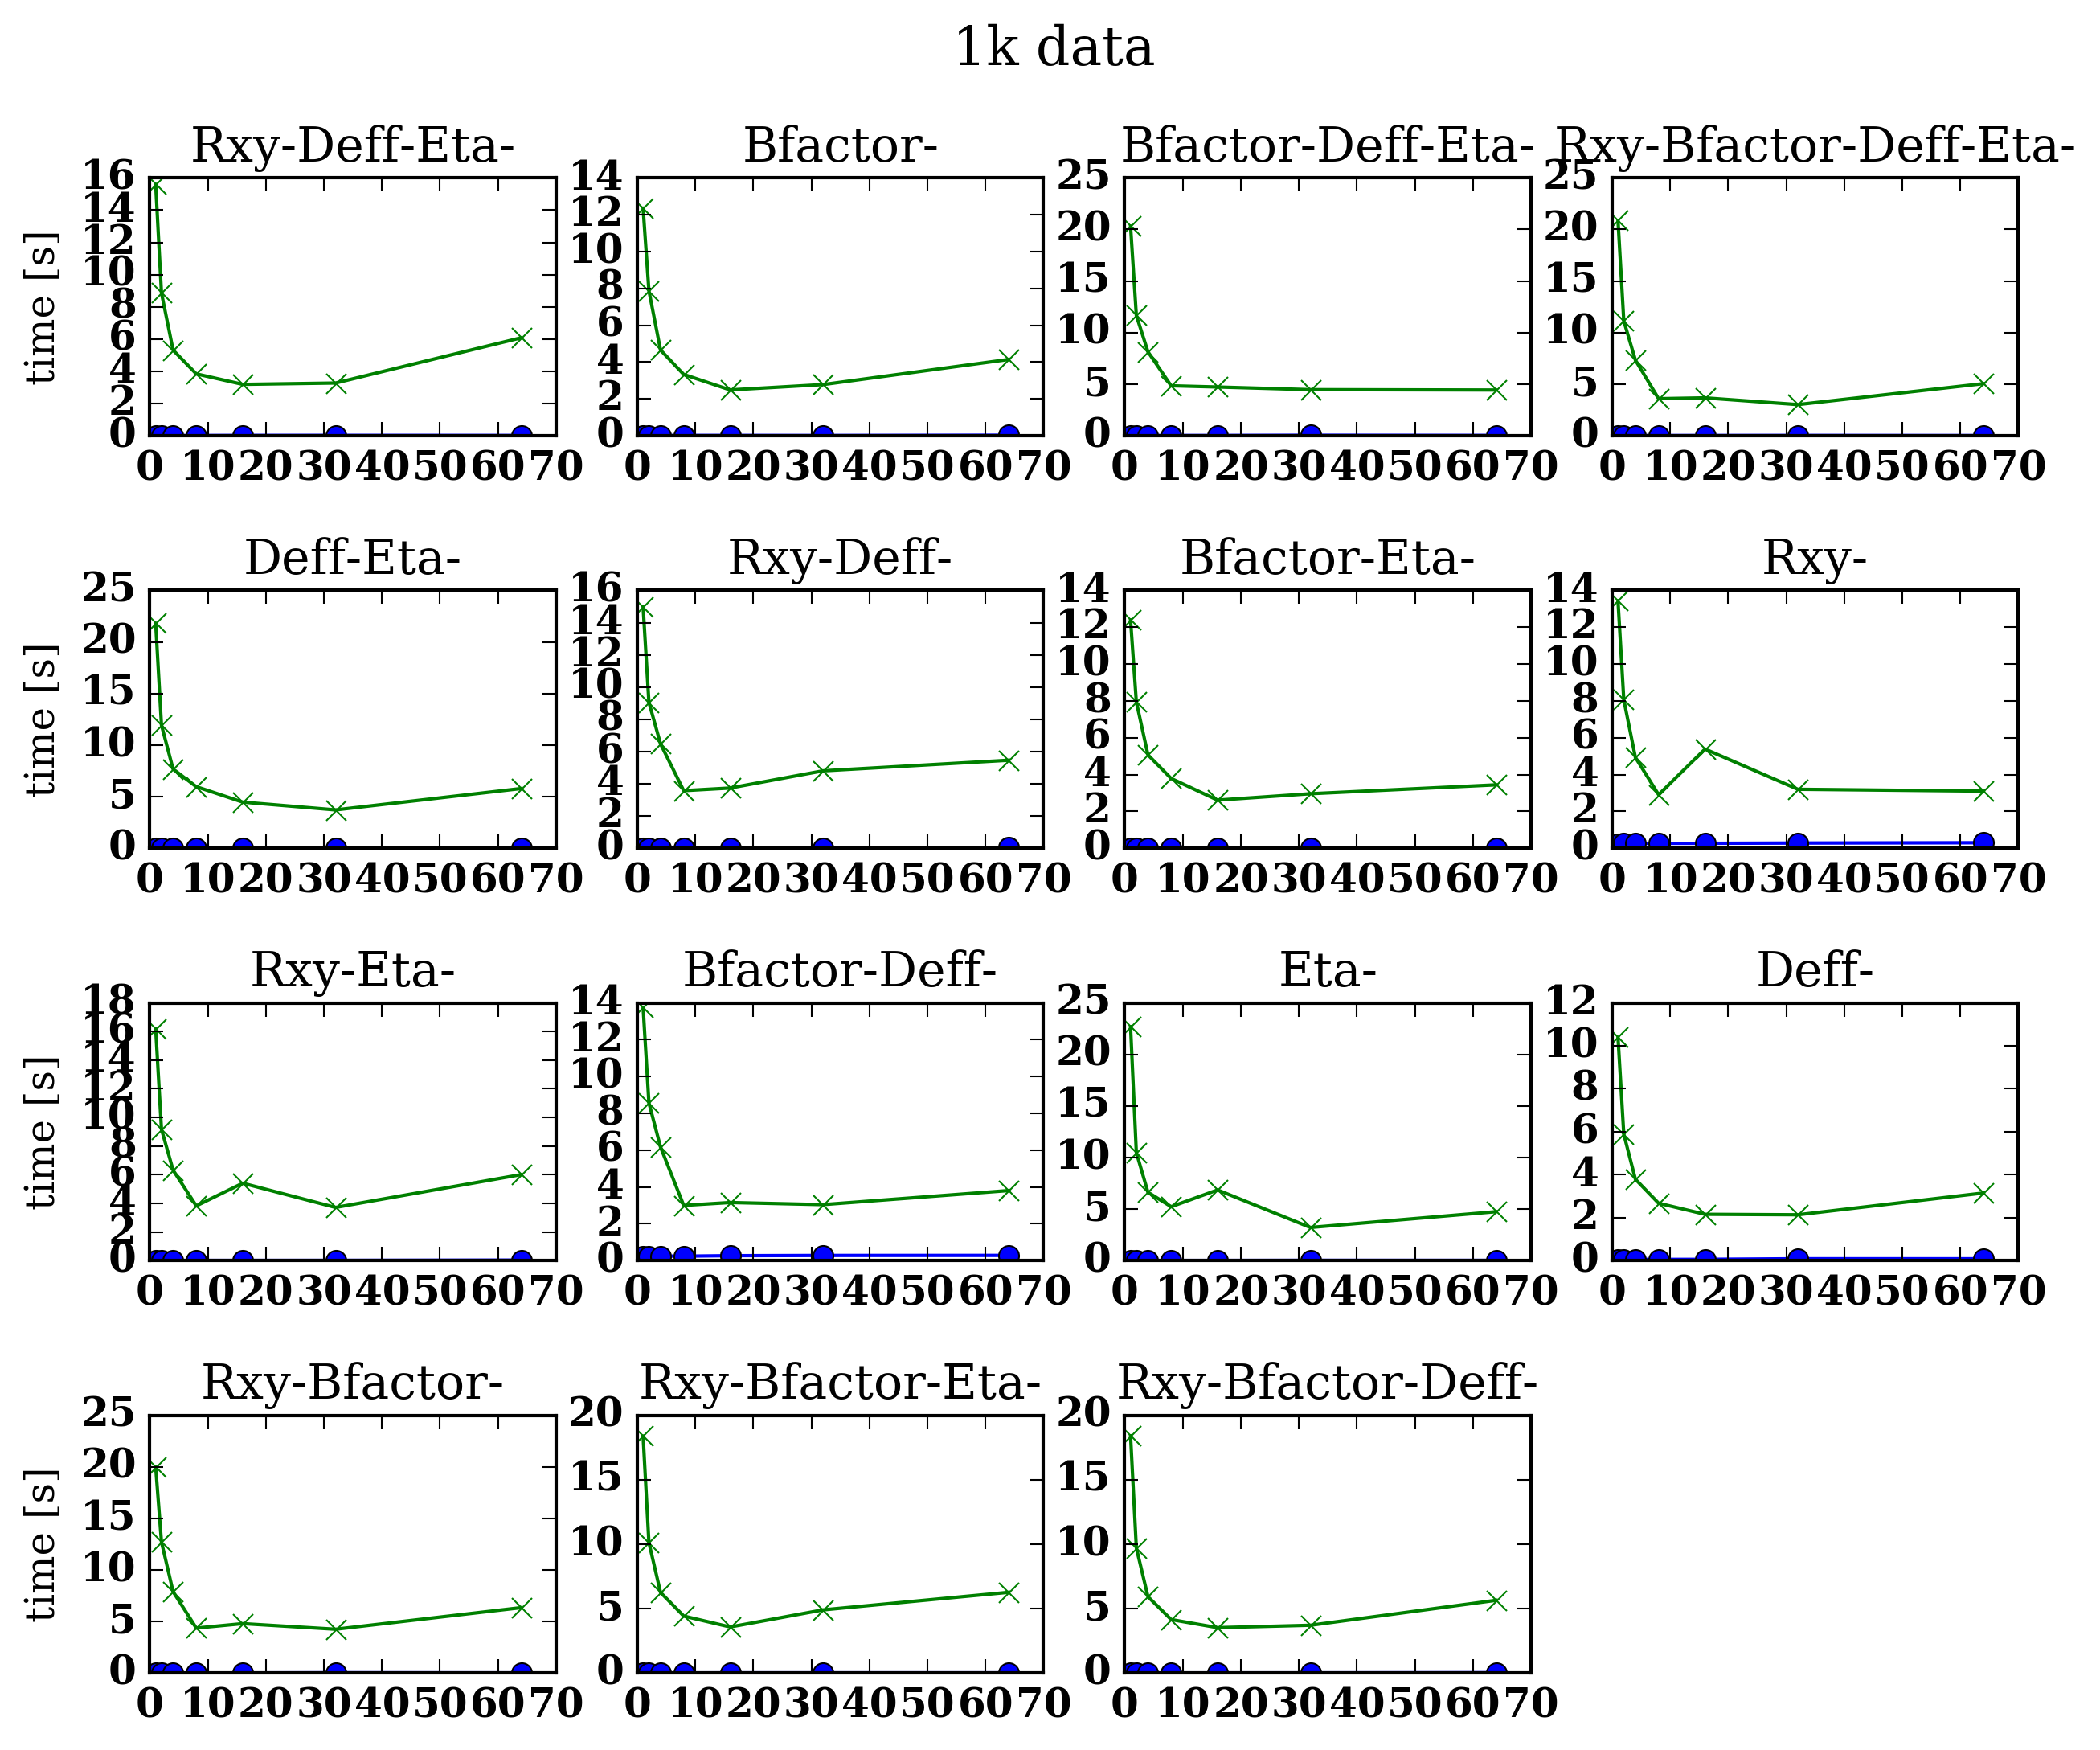

In [322]:
# define the figure size and grid layout properties
figsize = (10, 8)
cols = 4
gs = gridspec.GridSpec(cols, cols)
gs.update(hspace=0.6)
fig1 = plt.figure(num=1, figsize=figsize)

fig1.suptitle('1k data', size=16)

ax = []
for i, u in enumerate(uniq_ref):
    row = (i // cols)
    col = i % cols
    ax.append(fig1.add_subplot(gs[row, col]))
    if(col==0):
        ax[-1].set_ylabel('time [s]')
    ax[-1].set_title(str(u))
    ax[-1].plot(perf_s.index, perf_s['EIG_'+u], 'o', ls='-', ms=6)
    ax[-1].plot(perf_s.index, perf_s['STRUM_'+u], 'x', ls='-', ms=6)

As expected, the OMP_NUM_THREADS variable allowed the STRUMPACK code to improve in performance, but for this data size EIGEN clearly offers better performance. Next we increase the number of frames in the dataset by a factor of 5, and perform the same analysis. 